In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

from tabulate import tabulate
from termcolor import colored

In [2]:
from my_area_stats import val_per_area

In [3]:
style.use('dark_background')
input_output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???

place_name = 'Amsterdam'
local_crs = 'EPSG:28992'
sub_folder = str(place_name).replace(' ', '')+'_14Apr2022'

# Load data

In [5]:
value_col = '_Betweenness'
id_col = '__GUID'

In [6]:
place = gpd.read_file(os.path.join(os.path.join(input_output_folder, sub_folder), 'place.geojson'))
place.crs = local_crs

# With detours

In [7]:
betw_radius = 800
filename = 'betw_adl_{}_dr12.geojson'.format(str(betw_radius))
betw_adl_1 = gpd.read_file(os.path.join(os.path.join(input_output_folder, sub_folder), filename))
betw_adl_1 = betw_adl_1[betw_adl_1.geometry.type == 'LineString']
betw_adl_1.crs = local_crs
betw_adl_1[value_col] = betw_adl_1[value_col].astype(float)
col_adl = 'betw_adl_{}_dr12'.format(str(betw_radius))
betw_adl_1[col_adl] = betw_adl_1[value_col]

In [8]:
betw_radius = 1000
filename = 'betw_adl_{}_dr12.geojson'.format(str(betw_radius))
betw_adl_2 = gpd.read_file(os.path.join(os.path.join(input_output_folder, sub_folder), filename))
betw_adl_2 = betw_adl_2[betw_adl_2.geometry.type == 'LineString']
betw_adl_2.crs = local_crs
betw_adl_2[value_col] = betw_adl_2[value_col].astype(float)
col_adl = 'betw_adl_{}_dr12'.format(str(betw_radius))
betw_adl_2[col_adl] = betw_adl_2[value_col]

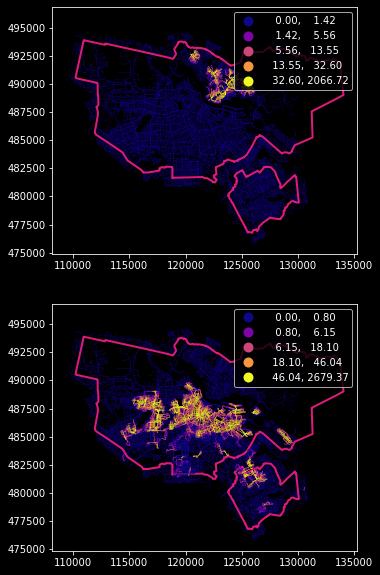

In [9]:
betw_radius = 1200
if place_name == 'Amsterdam':
    filename = 'betw_adl_{}north_dr12.geojson'.format(str(betw_radius))
    betw_adl_3 = gpd.read_file(os.path.join(os.path.join(input_output_folder, sub_folder), filename))
    betw_adl_3 = betw_adl_3[betw_adl_3.geometry.type == 'LineString']
    betw_adl_3.crs = local_crs
    betw_adl_3[value_col] = betw_adl_3[value_col].astype(float)
    col_adl = 'betw_adl_{}north_dr12'.format(str(betw_radius))
    betw_adl_3[col_adl] = betw_adl_3[value_col]
    
    filename_s = 'betw_adl_{}south_dr12.geojson'.format(str(betw_radius))
    betw_adl_3s = gpd.read_file(os.path.join(os.path.join(input_output_folder, sub_folder), filename_s))
    betw_adl_3s = betw_adl_3s[betw_adl_3s.geometry.type == 'LineString']
    betw_adl_3s.crs = local_crs
    betw_adl_3s[value_col] = betw_adl_3s[value_col].astype(float)
    col_adl = 'betw_adl_{}south_dr12'.format(str(betw_radius))
    betw_adl_3s[col_adl] = betw_adl_3s[value_col]
    
    
    
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

    col_adl = 'betw_adl_1200north_dr12'
    betw_adl_3.plot(ax=axs[0], color='#130689', zorder=1, linewidth=0.2)
    betw_adl_3[betw_adl_3[col_adl]>0].plot(ax=axs[0], column=col_adl, cmap='plasma', scheme='quantiles', zorder=2, legend=True, linewidth=0.5)
    place.plot(ax=axs[0], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)

    col_adl = 'betw_adl_1200south_dr12'
    betw_adl_3s.plot(ax=axs[1], color='#130689', zorder=1, linewidth=0.2)
    betw_adl_3s[betw_adl_3s[col_adl]>0].plot(ax=axs[1], column=col_adl, cmap='plasma', scheme='quantiles', zorder=2, legend=True, linewidth=0.5)
    place.plot(ax=axs[1], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)

    plt.show()
    
    
    
    betw_adl_3 = betw_adl_3[[id_col, 'betw_adl_{}north_dr12'.format(str(betw_radius)), 'geometry']].merge(
        betw_adl_3s[[id_col, 'betw_adl_{}south_dr12'.format(str(betw_radius))]], how='left', on=id_col)
    col_adl = 'betw_adl_{}_dr12'.format(str(betw_radius))
    betw_adl_3[col_adl] = betw_adl_3['betw_adl_{}north_dr12'.format(str(betw_radius))] + betw_adl_3['betw_adl_{}south_dr12'.format(str(betw_radius))]

In [10]:
if place_name != 'Amsterdam':
    betw_radius = 1200
    filename = 'betw_adl_{}_dr12.geojson'.format(str(betw_radius))
    betw_adl_3 = gpd.read_file(os.path.join(os.path.join(input_output_folder, sub_folder), filename))
    betw_adl_3 = betw_adl_3[betw_adl_3.geometry.type == 'LineString']
    betw_adl_3.crs = local_crs
    betw_adl_3[value_col] = betw_adl_3[value_col].astype(float)
    col_adl = 'betw_adl_{}_dr12'.format(str(betw_radius))
    betw_adl_3[col_adl] = betw_adl_3[value_col]

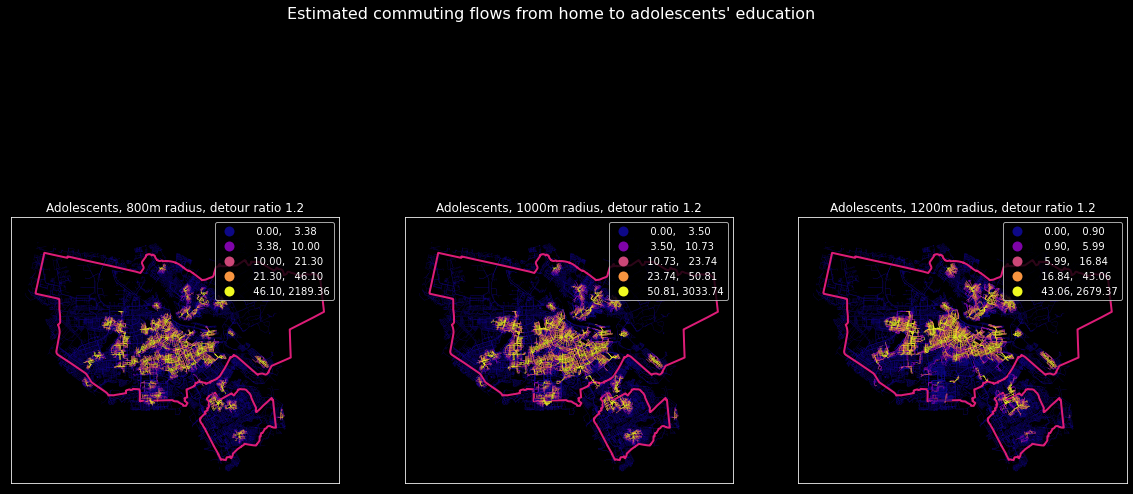

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
fig.suptitle('Estimated commuting flows from home to adolescents\' education', fontsize=16)

col_adl = 'betw_adl_800_dr12'
betw_adl_1.plot(ax=axs[0], color='#130689', zorder=1, linewidth=0.2)
betw_adl_1[betw_adl_1[col_adl]>0].plot(ax=axs[0], column=col_adl, cmap='plasma', scheme='quantiles', zorder=2, legend=True, linewidth=0.5)
place.plot(ax=axs[0], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)
axs[0].set_title('Adolescents, 800m radius, detour ratio 1.2')

col_adl = 'betw_adl_1000_dr12'
betw_adl_2.plot(ax=axs[1], color='#130689', zorder=1, linewidth=0.2)
betw_adl_2[betw_adl_2[col_adl]>0].plot(ax=axs[1], column=col_adl, cmap='plasma', scheme='quantiles', zorder=2, legend=True, linewidth=0.5)
place.plot(ax=axs[1], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)
axs[1].set_title('Adolescents, 1000m radius, detour ratio 1.2')

col_adl = 'betw_adl_1200_dr12'
betw_adl_3.plot(ax=axs[2], color='#130689', zorder=1, linewidth=0.2)
betw_adl_3[betw_adl_3[col_adl]>0].plot(ax=axs[2], column=col_adl, cmap='plasma', scheme='quantiles', zorder=2, legend=True, linewidth=0.5)
place.plot(ax=axs[2], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)
axs[2].set_title('Adolescents, 1200m radius, detour ratio 1.2')

for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

plt.show()

# Merge results

In [12]:
betw = betw_adl_1[[id_col, 'betw_adl_800_dr12', 'geometry']].merge(
    betw_adl_2[[id_col, 'betw_adl_1000_dr12']], how='left', on=id_col).merge(
    betw_adl_3[[id_col, 'betw_adl_1200_dr12']], how='left', on=id_col)

#  Store output data

In [13]:
output_sub_folder = os.path.join(input_output_folder, sub_folder)

In [14]:
if not os.path.exists(output_sub_folder):
    os.mkdir(output_sub_folder)

In [15]:
output_file = os.path.join(output_sub_folder, 'ALTERNATIVE_betw_complete.geojson')
betw.to_file(output_file, driver='GeoJSON')